In [1]:
%pylab inline

/home/gjones/miniconda2/envs/readout/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
from kid_readout.interactive import *

INFO     2016-09-01 16:06:19,585 - kid_readout.<module>:13  kid_readout logging setup with default stream handler


In [3]:
logger.setLevel(logging.DEBUG)

In [4]:
%time ri = hardware_tools.r2_with_mk1()

DEBUG    2016-09-01 16:06:22,707 - kid_readout.roach.interface.__init__:65  Creating FpgaClient
DEBUG    2016-09-01 16:06:22,708 - kid_readout.roach.interface.__init__:69  Waiting for connection to ROACH
DEBUG    2016-09-01 16:06:22,708 - kid_readout.roach.interface.__init__:74  ROACH is connected
INFO     2016-09-01 16:06:23,537 - kid_readout.roach.interface.initialize:434  Loaded ROACH state from /data/readout/r2kid_config.npz
DEBUG    2016-09-01 16:06:23,541 - kid_readout.roach.interface.initialize:443  Programmed boffile crc: 1937513389
DEBUG    2016-09-01 16:06:23,645 - kid_readout.roach.r2heterodyne.initialize:61  Started tap interface
DEBUG    2016-09-01 16:06:23,647 - kid_readout.roach.r2heterodyne.initialize:63  Checking QDR calibration
DEBUG    2016-09-01 16:06:23,705 - kid_readout.roach.r2heterodyne.initialize:70  Calibrating QDR
INFO     2016-09-01 16:06:26,843 - kid_readout.roach.r2heterodyne.initialize:72  Succesfully recalibrated QDR


CPU times: user 2.45 s, sys: 302 ms, total: 2.75 s
Wall time: 4.18 s


In [5]:
ri.iq_delay=0

In [6]:
ri.r.est_brd_clk()

256.5197215

In [7]:
ri.set_loopback(True)
ri.set_fft_gain(0)

INFO     2016-09-01 16:06:33,600 - kid_readout.roach.interface.set_fft_gain:307  Set FFT gain integer to 0.


In [8]:
import time

In [12]:
from kid_readout.roach import demodulator
reload(demodulator)

<module 'kid_readout.roach.demodulator' from '/home/gjones/kid_readout/kid_readout/roach/demodulator.pyc'>

In [24]:
nchan=128
freqs = np.linspace(12.3123, 252.123,num=nchan)
ri.set_tone_baseband_freqs(freqs,nsamp=2**17)
ri.select_fft_bins(range(nchan))
gold_data,_ = ri.get_data(ri.blocks_per_second,demod=True)
raw_data,raw_seqno = ri.get_data(ri.blocks_per_second,demod=False)
stream_demod = demodulator.get_stream_demodulator_from_roach_state(ri.state,ri.active_state_arrays)
demod_data = stream_demod.demodulate_stream(raw_data,raw_seqno-ri.phase0)

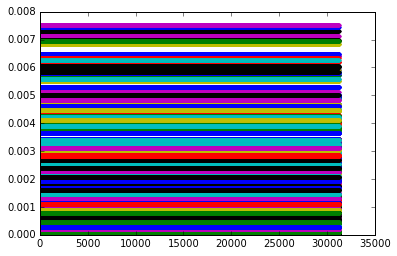

In [28]:
_ = plot(np.abs(gold_data-gold_data.mean(0))/np.abs(gold_data).mean(),'.')

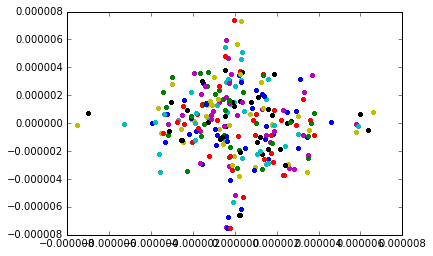

In [25]:
plot_ri(demod_data-gold_data,'.')

# Demonstrating phase problem
Reading out 512 channels, switching between two adjacent tone bins, the phase is sometimes (often) off by pi (negative)
The first plot, 512 channels, $2^{15}$ tone_nsamp shows expected behavior: the two adjacent channels have alomost identical phase. Going to $2^{16}$ tone_nsamp shows bad behavior. The same is seen reading out fewer channels when tone_nsamp is correspondingly higher

channel 0 delay: 4.7 rad/MHz
channel 8 delay: 4.4 rad/MHz
channel 16 delay: 5.7 rad/MHz
channel 24 delay: 1.6 rad/MHz
channel 32 delay: 1.9 rad/MHz
channel 40 delay: 2.5 rad/MHz
channel 48 delay: 2.1 rad/MHz
channel 56 delay: 4.4 rad/MHz
channel 64 delay: 6.7 rad/MHz
channel 72 delay: 5.2 rad/MHz
channel 80 delay: 3.1 rad/MHz
channel 88 delay: 1.6 rad/MHz
channel 96 delay: 4.0 rad/MHz
channel 104 delay: 1.2 rad/MHz
channel 112 delay: 3.3 rad/MHz
channel 120 delay: 1.3 rad/MHz
channel 0 delay: -398.7 rad/MHz
channel 8 delay: 407.2 rad/MHz
channel 16 delay: 407.4 rad/MHz
channel 24 delay: 406.5 rad/MHz
channel 32 delay: 405.8 rad/MHz
channel 40 delay: -398.7 rad/MHz
channel 48 delay: 406.4 rad/MHz
channel 56 delay: 406.3 rad/MHz
channel 64 delay: -398.6 rad/MHz
channel 72 delay: -398.9 rad/MHz
channel 80 delay: -397.4 rad/MHz
channel 88 delay: 407.6 rad/MHz
channel 96 delay: 405.9 rad/MHz
channel 104 delay: 406.5 rad/MHz
channel 112 delay: 405.8 rad/MHz
channel 120 delay: -397.7 rad/MHz


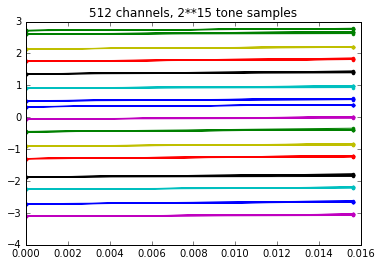

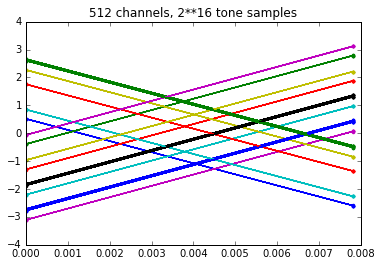

In [8]:
nchan = 512
for nsamp in [2**15, 2**16]:
    # measure repeatedly at 0 offset and one tone bin offset
    offsets = np.ones(12)
    offsets[::2]=0
    offsets = (512./nsamp)*offsets
    base = np.linspace(20.0,250.0,512)
    
    dset = []
    seqnos = []
    for k,offset in enumerate(offsets):
        _=ri.set_tone_baseband_freqs(base+offset,nsamp=nsamp)

        ri.select_fft_bins(range(len(base)))
        time.sleep(np.random.random())
        data,seqno = ri.get_data(ri.blocks_per_second*.1,demod=True)
        dset.append(data)
        seqnos.append(seqno[0])
    seqnos = np.array(seqnos,dtype='u4')
    figure()
    for chan in range(0,128,8): #just picking some random channels, doesn't seem to matter which ones
        chan1 = np.array([dd[:,chan] for dd in dset])
        _ = plot(offsets,np.angle(chan1.T).mean(0),'.-')
        print "channel %d delay: %.1f rad/MHz" % (chan,np.diff((np.angle(chan1.T).mean(0))).mean()/np.diff(offsets).mean())
    title("%d channels, 2**%d tone samples" % (nchan, np.log2(nsamp)))

# Seems like it might have to do with odd channels
Here is the same test, but reading out three adjacent channels. The middle (odd channel) shows the strange behavior.

channel 0 delay: 4.2 rad/MHz
channel 8 delay: 4.4 rad/MHz
channel 16 delay: 3.9 rad/MHz
channel 24 delay: 4.0 rad/MHz
channel 32 delay: 4.2 rad/MHz
channel 40 delay: 4.1 rad/MHz
channel 48 delay: 4.0 rad/MHz
channel 56 delay: 4.0 rad/MHz
channel 64 delay: 4.3 rad/MHz
channel 72 delay: 4.0 rad/MHz
channel 80 delay: 3.9 rad/MHz
channel 88 delay: 4.2 rad/MHz
channel 96 delay: 4.3 rad/MHz
channel 104 delay: 4.3 rad/MHz
channel 112 delay: 4.2 rad/MHz
channel 120 delay: 4.0 rad/MHz
channel 0 delay: 4.1 rad/MHz
channel 8 delay: 4.8 rad/MHz
channel 16 delay: 4.4 rad/MHz
channel 24 delay: 3.9 rad/MHz
channel 32 delay: 4.4 rad/MHz
channel 40 delay: 4.3 rad/MHz
channel 48 delay: 3.8 rad/MHz
channel 56 delay: 3.9 rad/MHz
channel 64 delay: 3.8 rad/MHz
channel 72 delay: 4.4 rad/MHz
channel 80 delay: 4.1 rad/MHz
channel 88 delay: 3.9 rad/MHz
channel 96 delay: 4.2 rad/MHz
channel 104 delay: 4.3 rad/MHz
channel 112 delay: 4.5 rad/MHz
channel 120 delay: 4.2 rad/MHz


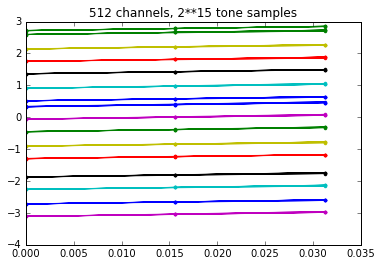

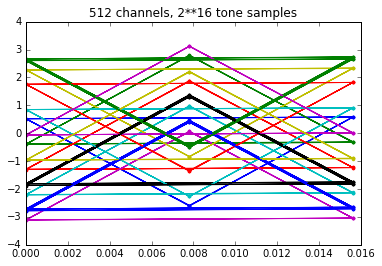

In [9]:
nchan = 512
for nsamp in [2**15, 2**16]:
    # measure repeatedly at 0 offset and one tone bin offset
    offsets = np.ones(12)
    offsets[::3]=0
    offsets[2::3]=2
    offsets = (512./nsamp)*offsets
    base = np.linspace(20.0,250.0,512)
    
    dset = []
    seqnos = []
    for k,offset in enumerate(offsets):
        _=ri.set_tone_baseband_freqs(base+offset,nsamp=nsamp)

        ri.select_fft_bins(range(len(base)))
        time.sleep(np.random.random())
        data,seqno = ri.get_data(ri.blocks_per_second*.1,demod=True)
        dset.append(data)
        seqnos.append(seqno[0])
    seqnos = np.array(seqnos,dtype='u4')
    figure()
    for chan in range(0,128,8):
        chan1 = np.array([dd[:,chan] for dd in dset])
        _ = plot(offsets,np.angle(chan1.T).mean(0),'.-')
        print "channel %d delay: %.1f rad/MHz" % (chan,np.diff((np.angle(chan1.T).mean(0))).mean()/np.diff(offsets).mean())
    title("%d channels, 2**%d tone samples" % (nchan, np.log2(nsamp)))

channel 0 delay: -27.4 rad/MHz


IndexError: index 8 is out of bounds for axis 1 with size 4

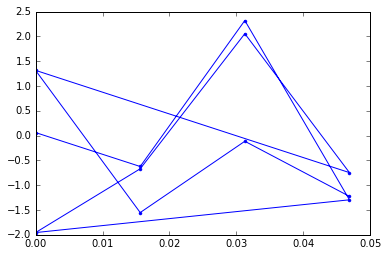

In [30]:
nchan = 4
for nsamp in [2**15]:#, 2**16]:
    # measure repeatedly at 0 offset and one tone bin offset
    offsets = np.ones(12)
    offsets[::4]=0
    offsets[2::4]=2
    offsets[3::4]=3
    offsets = (512./nsamp)*offsets
    base = np.linspace(20.0,250.0,nchan)
    
    dset = []
    seqnos = []
    for k,offset in enumerate(offsets):
        _=ri.set_tone_baseband_freqs(base+offset,nsamp=nsamp)

        ri.select_fft_bins(range(len(base)))
        time.sleep(np.random.random())
        data,seqno = ri.get_data(8,demod=False)
        dset.append(data)
        seqnos.append(seqno[0])
    seqnos = np.array(seqnos,dtype='u4')
    figure()
    for chan in range(0,128,8):
        chan1 = np.array([dd[:,chan] for dd in dset])
        _ = plot(offsets,np.angle(chan1.T).mean(0),'.-')
        print "channel %d delay: %.1f rad/MHz" % (chan,np.diff((np.angle(chan1.T).mean(0))).mean()/np.diff(offsets).mean())
    title("%d channels, 2**%d tone samples" % (nchan, np.log2(nsamp)))

In [36]:
(np.mod(seqno-ri.phase0,2**14))

array([0, 0, 0, ..., 0, 0, 0], dtype=uint32)

In [37]:
np.mod(ri.phase0,16384)

258

In [9]:
from kid_readout.roach import demodulator
reload(demodulator)

<module 'kid_readout.roach.demodulator' from '/home/gjones/kid_readout/kid_readout/roach/demodulator.pyc'>

In [53]:
ri.set_tone_baseband_freqs(np.array([123.123,125.223]),nsamp=2**18)

array([ 123.12304688,  125.22265625])

In [64]:
np.linspace(12.3123,252,2)

array([  12.3123,  252.    ])

In [54]:
ri.select_fft_bins([0,1])

In [55]:
data,seqno = ri.get_data(8,demod=True)

In [56]:
data2,seqno = ri.get_data(8,demod=False)

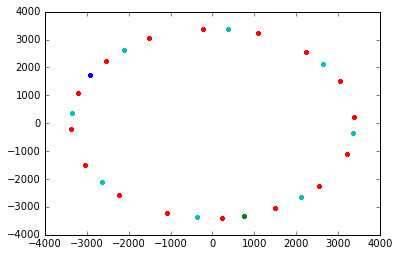

In [57]:
plot_ri(data,'.')
plot_ri(data2,'.')


In [58]:
sd = demodulator.get_stream_demodulator_from_roach_state(ri.state,ri.active_state_arrays)

In [59]:
demwav,period = sd.create_demodulation_waveform(data2.shape,seqno-ri.phase0,)

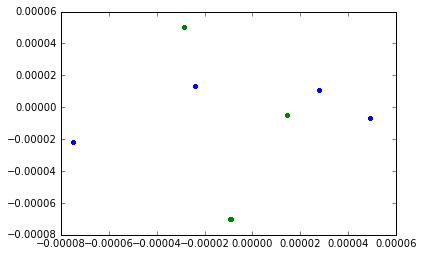

In [62]:
plot_ri(data-data2*demwav,'.')
#plot_ri(,'x')

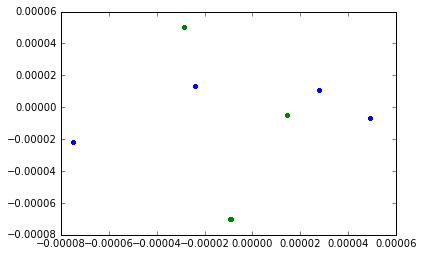

In [67]:
plot_ri(data-sd.demodulate_stream(data2,seqno-ri.phase0),'.')

In [51]:
demwav.shape

(8192, 1)

In [16]:
period

4

In [21]:
data.shape

(2048, 512)

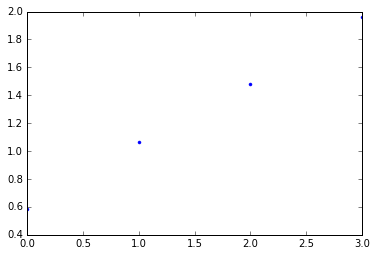

In [34]:
plot(np.angle(data*demwav).mean(0),'.')

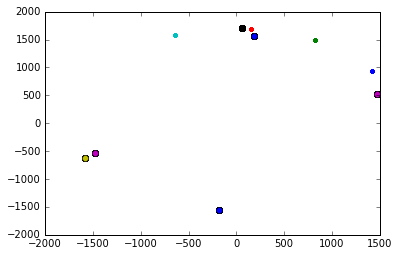

In [37]:
plot_ri(data*demwav,'.')
plot_ri(data,'o')

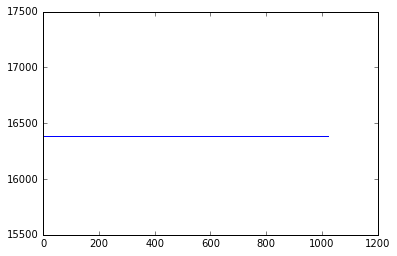

In [32]:
plot(np.diff(seqno/16))

In [18]:
data.shape

(2048, 512)

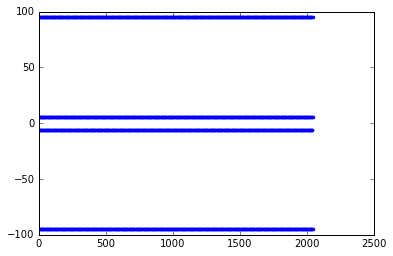

In [24]:
plot(data.imag[:,1],'.')

# Further tests below here, undocumented

In [70]:
def packet_phase(seq_no,offset_frequencies,nchan,nfft,ns):
    packet_bins = 1024    #this is hardcoded from the roach. number of fft bins that fit in 1 udp packet
    packet_counts = nfft * packet_bins
    chan_counts = packet_counts / nchan
    shift = int(np.log2(chan_counts)) - 1
    modn = ns / chan_counts
    print shift, modn, chan_counts, packet_counts
    if modn == 0:
        modn = 1
    multy = ns / nfft
#    print multy, modn
    seq_no = seq_no >> shift
    print seq_no
    seq_no %= modn
    print seq_no,multy,modn,offset_frequencies.min(),offset_frequencies[0]*multy,np.mod(2*(offset_frequencies[0]*seq_no * multy) / modn,2)
    return np.exp(-1j * 2. * np.pi * seq_no * offset_frequencies * multy / modn)

def tone_offset_frequency(tone_bin,tone_num_samples,fft_bin,nfft):
    k = tone_bin
    m = fft_bin
    nfft = nfft
    ns = tone_num_samples
    return nfft * (k / float(ns)) - m

In [117]:
#        data = ri.demodulate_data(data)
#        pphase = packet_phase(seqno[0]-ri.phase0,tone_offset_frequency(ri.tone_bins[0,:],nsamp,ri.fft_bins[0,:],2**14),256,2**14,nsamp)
#        print hex(seqno[0]-ri.phase0),np.mod(np.angle(pphase[0])/np.pi,2),np.mod(np.angle(data[:,0].mean(0))/np.pi,2)
        #packet_phase(seqno[:2]-ri.phase0,tone_offset_frequency(ri.tone_bins[0,0],2**17,ri.fft_bins[0,0],2**14),256,2**14,2**17)[:2]
    #    data *= pphase
        #demodulator = ri.get_stream_demodulator()
        #dset.append(demodulator.demodulate_stream(data,seqno))


In [63]:
seqno[0]

3947708896

In [65]:
hex(ri.phase0)

'0xee26ff22L'

In [66]:
hex(seqno[0]-ri.phase0)

'0xfd2642beL'

4.24201214314
405.963096619
4.16509991884
405.99388504
3.56018078327
-397.844272614
406.965602875
4.33862316608
-397.992794037
4.44081133604
-397.711585999
4.18224316835
405.818153381
3.3274230361
-397.581409454
3.01028439403


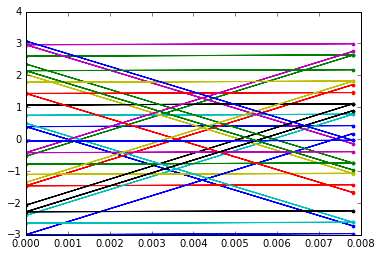

In [103]:
for chan in range(0,128,8):
    chan1 = np.array([dd[:,chan] for dd in dset])
    _ = plot(offsets,np.angle(chan1.T).mean(0),'.-')
    print np.diff((np.angle(chan1.T).mean(0))).mean()/np.diff(offsets).mean()
#plot(offsets,offsets*200.75)

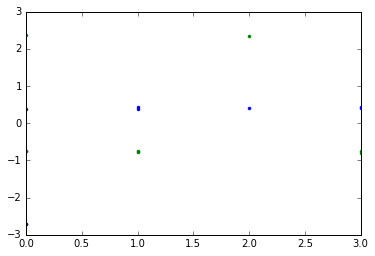

In [116]:
for chan in range(0,128,64):
    chan1 = np.array([dd[:,chan] for dd in dset])
    _ = plot(np.mod((seqnos-ri.phase0)//2**14,4),np.angle(chan1[:,0]),'.')
    #print np.diff((np.angle(chan1.T).mean(0))).mean()/np.diff(offsets).mean()
#plot(offsets,offsets*200.75)

In [91]:
np.mod((seqnos-ri.phase0)//2**14,16)

array([ 1, 12, 13,  7,  8,  9, 15,  1], dtype=uint32)

In [38]:
chan1.shape

(8, 3128)

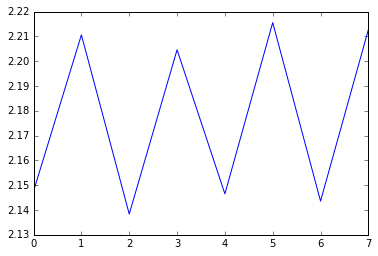

In [48]:
plot(np.angle(chan1.mean(1)))

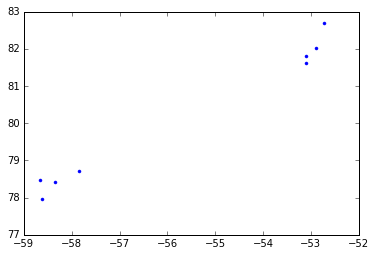

In [49]:
plot_ri(chan1.mean(1),'.')

In [50]:
dd.shape

(3126, 512)

In [390]:
np.exp(1j*np.angle(-1))

(-1+1.2246063538223773e-16j)

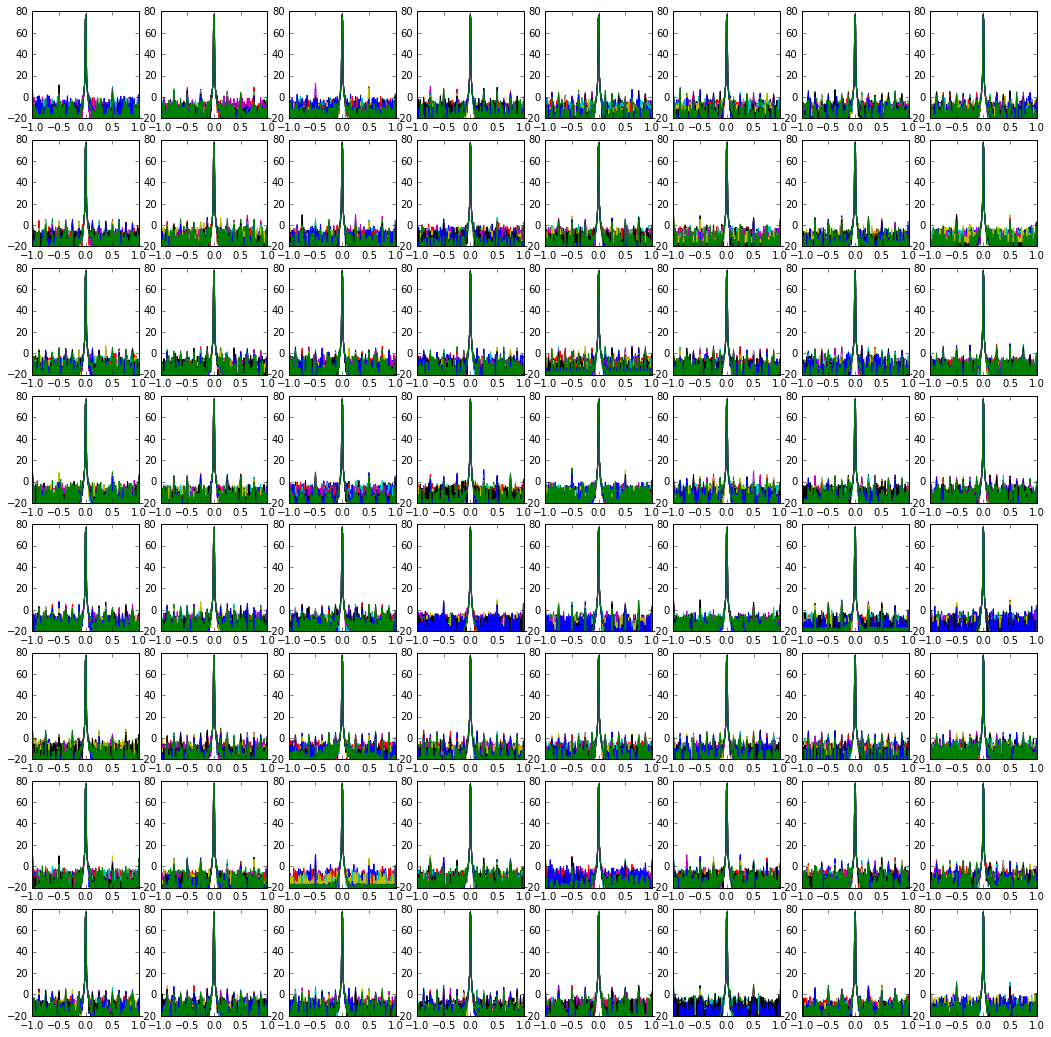

In [332]:
fig,axs = plt.subplots(8,8,figsize=(18,18))
for offset,dd in zip(offsets,dset):
    for k in range(64):
        ax = axs.flatten()[k]
        pxx,fr = mlab.psd(dd[:,k])
        ax.plot(fr,10*np.log10(pxx))
        ax.set_ylim(-20,80)

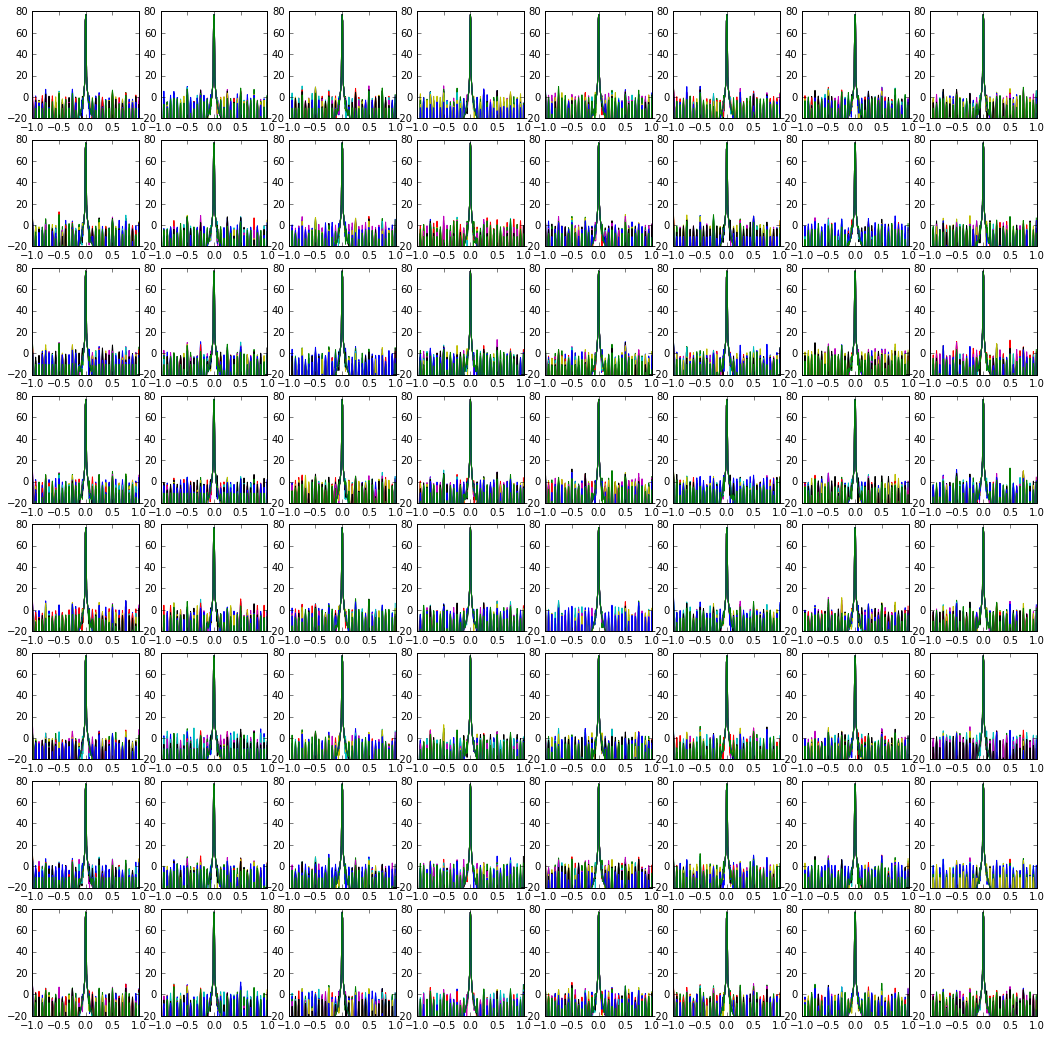

In [323]:
fig,axs = plt.subplots(8,8,figsize=(18,18))
for offset,dd in zip(offsets,dset):
    for k in range(64):
        ax = axs.flatten()[k]
        pxx,fr = mlab.psd(dd[:,k])
        ax.plot(fr,10*np.log10(pxx))
        ax.set_ylim(-20,80)

In [297]:
20*np.log10(2**13)

78.267798872635112

In [160]:
chan1.shape

(14, 1024)

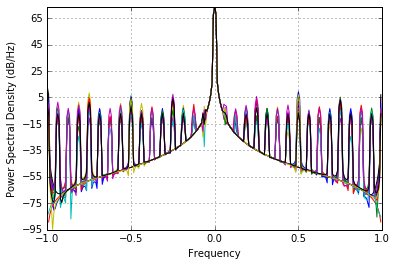

In [164]:
for c in chan1:
    _=psd(c)

In [36]:
4.68651/512.

0.00915333984375

In [308]:
.7458812323495985/1e6

7.458812323495985e-07

In [309]:
.74588*512

381.89056

In [186]:
512*200/(2*np.pi)

16297.466172610082

In [135]:
114709/256e6

0.00044808203125

In [133]:
ri.demodulator.hardware_delay_samples

0.0

In [307]:
sdm.hardware_delay_samples

-16025.6

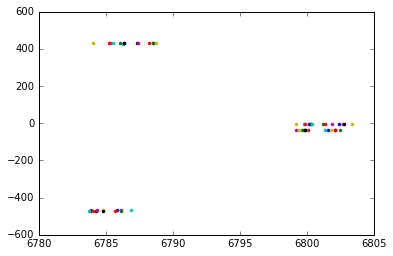

In [182]:
for dd,offset in zip(dset,offsets):
    #plot(base+offset,np.angle(dd.mean(0)*np.exp(1j*(base+offset)*6.07)),'.')
    plot_ri(dd.mean(0)*np.exp(-1j*(base+offset)*200.76743),'.')
#xlim(50.1,50.2)

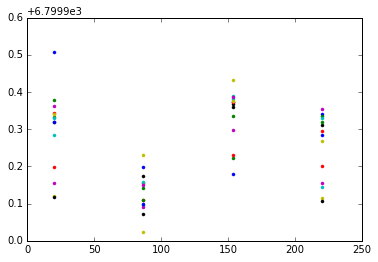

In [184]:
for dd,offset in zip(dset,offsets):
    plot(base+offset,np.abs(dd).mean(0),'.')
#    xlim(50,54)

In [ ]:
plot(base+offset,np.angle(dd.mean(0)*np.exp(1j*(base+offset)*603.48)))

In [79]:
dd.shape

(256, 512)

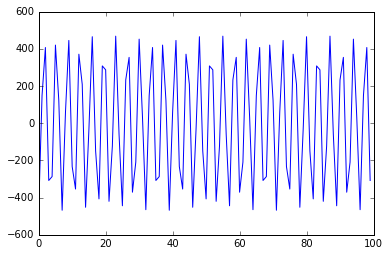

In [95]:
plot(data[:,30].real[:100])

In [55]:
dd.real.shape

(256, 512)

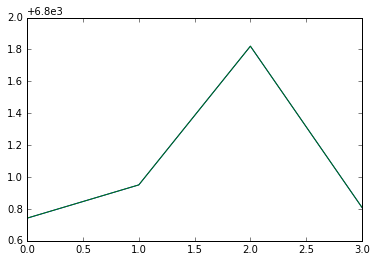

In [185]:
plot(np.abs(data).max(0))
plot(np.abs(dd).max(0))

In [ ]:
-4.67*1e6

In [185]:
np.abs(np.diff(ri.fft_bins.squeeze())).min()

12

In [186]:
ri.select_fft_bins(range(512))

In [24]:
sdm = ri.get_stream_demodulator()

In [ ]:
sdm.demodulate_stream()

In [10]:
sdm.max_period

16

In [11]:
data,seqno = ri.get_data(1024,demod=False)

In [12]:
data.shape

(2048, 512)

In [13]:
demod = sdm.demodulate_stream(data,seqno-ri.phase0)

In [14]:
gold = ri.demodulate_data(data)#,seqno-ri.phase0)

In [15]:
np.allclose(gold,demod)

True

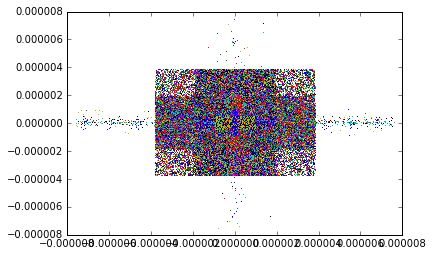

In [16]:
plot_ri(gold-demod,',')

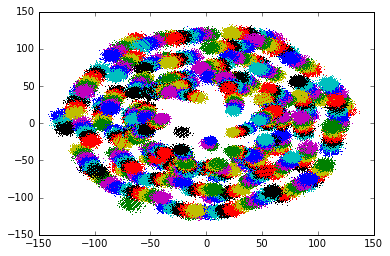

In [17]:
plot_ri(demod,',')

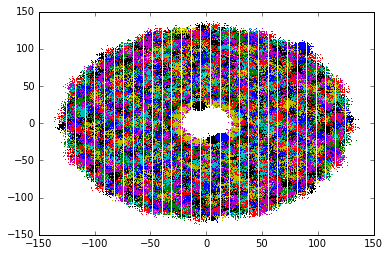

In [18]:
plot_ri(data,',')

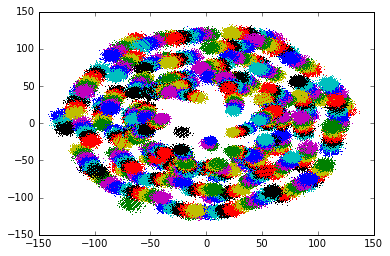

In [19]:
plot_ri(gold,',')

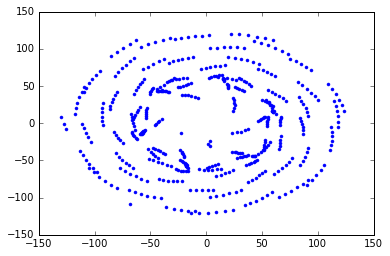

In [20]:
plot_ri(gold.mean(0),'.')

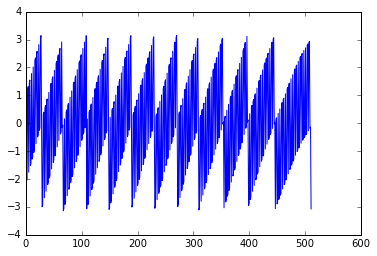

In [27]:
plot(np.angle(gold.mean(0)*np.exp(1j+1j*5.5*512.*sdm.tone_bins/float(sdm.tone_nsamp))))
#plot(np.angle(gold.mean(0)[:128]*np.exp(-300*2j*np.pi*sdm.tone_bins[:128]/float(sdm.tone_nsamp))))

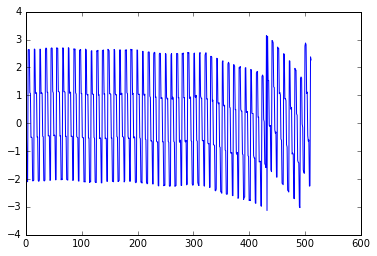

In [23]:
plot(np.angle(demod.mean(0)*np.exp(1j+1j*6.07*512.*sdm.tone_bins/float(sdm.tone_nsamp))))
#plot(np.angle(gold.mean(0)[:128]*np.exp(-300*2j*np.pi*sdm.tone_bins[:128]/float(sdm.tone_nsamp))))

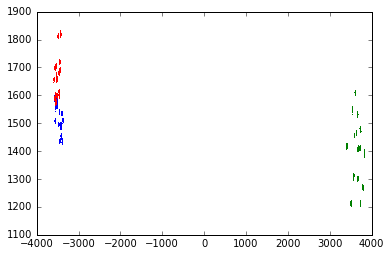

In [24]:
plot_ri(gold[:,0],',')
plot_ri(gold[:,1],',')
plot_ri(gold[:,2],',')


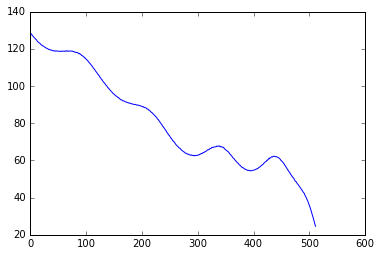

In [341]:
plot((np.abs(gold.mean(0))))

In [95]:
sdm.hardware_delay_samples

-16025.6

In [118]:
16384-16

16368

In [119]:
_+_95

342.39999999999964

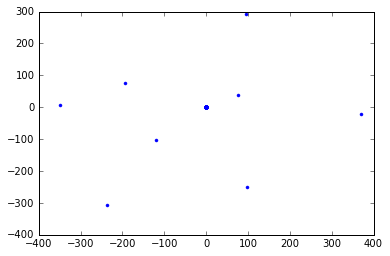

In [260]:
plot_ri((data.mean(0)*np.exp(0
                             *2j*np.pi*sdm.tone_bins/float(sdm.tone_nsamp))),'.')

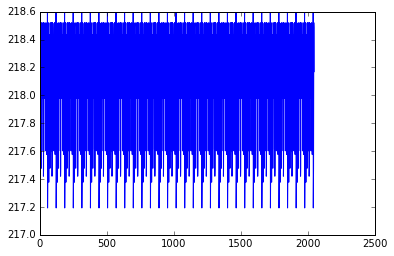

In [220]:
plot(gold[:,2])

In [221]:
gold.shape

(2048, 512)

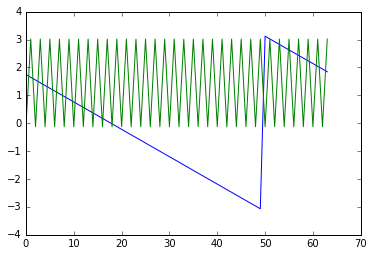

In [222]:
plot(np.angle(data[:64,40]))
plot(np.angle(data[:64,41]))


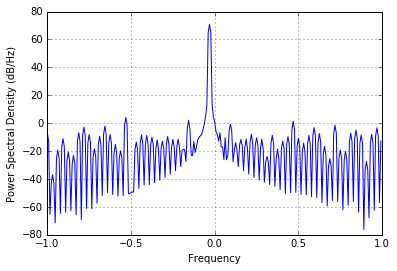

In [223]:
blah = psd(data[:,40])

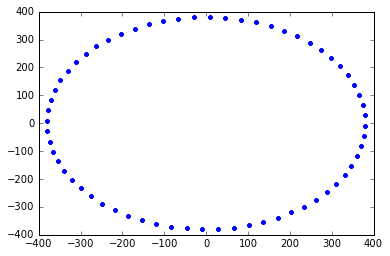

In [224]:
plot_ri(data[:,40],'.')

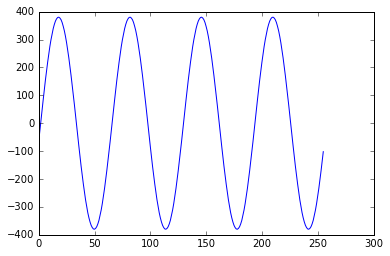

In [225]:
plot(data[:256,40])

In [226]:
seqno.shape

(1024,)

In [190]:
data.shape

(2048, 512)

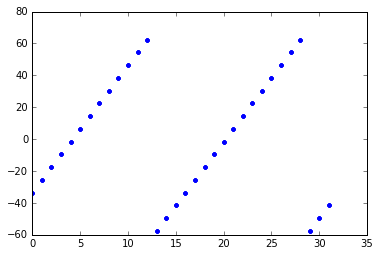

In [234]:
plot(np.mod((seqno)//16384,32),np.angle(data[::2,42])*64/np.pi,'.')

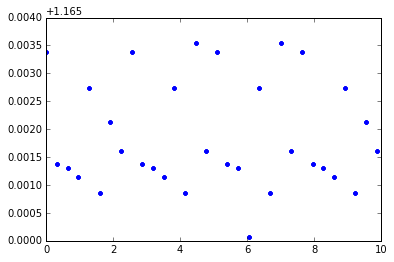

In [228]:
plot(np.mod((seqno)//16384,32)/np.pi,np.angle(gold[::2,40]),'.')

In [231]:
np.diff(seqno)

array([16384, 16384, 16384, ..., 16384, 16384, 16384], dtype=uint32)